# 1. Setup

## a. Run this first to setup django in this notebook

In [6]:
import os, django
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "backend.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

## b. Import django assets

In [7]:
from weather.models import *
from weather.tasks import *

## Import other libraries

In [8]:
from datetime import datetime
import datetime as dt
import pandas as pd
import numpy as np
from django_pandas.io import read_frame
import pytz
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.metrics import accuracy_score
import gc

# Stationary check
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

## b. Global variables (*)

In [9]:
dimensions = ['temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']
entry_cycle = 24

# 2. Experiments

## a. Get new entries

In [12]:
update_entry.delay()

<AsyncResult: 75f55d1a-89f1-48e9-98f5-fd2267c7e8d5>

## b. Check shape and nan values (whole dataset)

In [168]:
df = read_frame(Entry.objects.all())
print("Number of entry: ", df.shape[0])
print("Nan value check")
print(df.isna().sum())
print("Dataset overview")
print(df)

Number of entry:  63995
Nan value check
id      0
time    0
temp    0
dwpt    0
rhum    0
wdir    0
wspd    0
pres    0
coco    0
dtype: int64
Dataset overview
          id                      time  temp  dwpt   rhum   wdir  wspd  \
0          1 2017-01-01 00:00:00+00:00  23.0  23.0  100.0  350.0   7.6   
1          2 2017-01-01 01:00:00+00:00  25.0  23.1   89.0   20.0  11.2   
2          3 2017-01-01 02:00:00+00:00  28.0  21.1   66.0   40.0  11.2   
3          4 2017-01-01 03:00:00+00:00  30.0  21.1   59.0   30.0  14.8   
4          5 2017-01-01 04:00:00+00:00  31.0  20.0   52.0   20.0  13.0   
...      ...                       ...   ...   ...    ...    ...   ...   
63990  63998 2024-04-22 04:00:00+00:00  35.0  23.0   50.0  190.0  11.0   
63991  63999 2024-04-22 05:00:00+00:00  35.0  23.0   50.0  130.0  17.0   
63992  64000 2024-04-22 06:00:00+00:00  36.3  21.0   41.0   71.0   9.3   
63993  64001 2024-04-22 07:00:00+00:00  35.9  21.0   42.0   59.0  11.1   
63994  64002 2024-04-22 08

## c. Stationary check (Adfuller)

In [169]:
start_date = dt.datetime(2021, 1, 1).replace(tzinfo=pytz.UTC)
data = (read_frame(Entry.objects.filter(Q(time__gte=start_date)))[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)

In [170]:
dimension = "temp"
count = 24*4

### No difference

In [171]:
result_adf = adfuller(data[dimension])

# Print the results
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])
print('Critical Values:')
for key, value in result_adf[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -10.34437505354834
p-value: 2.634369461503578e-18
Critical Values:
   1%: -3.4305760900367592
   5%: -2.8616399255486886
   10%: -2.5668231873439074


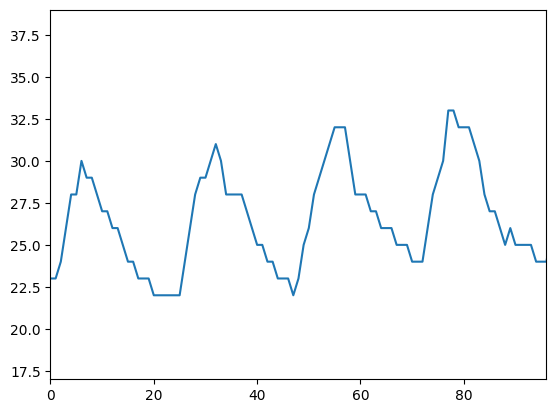

In [172]:
# Plotting temperature
plt.plot(data.index, data[dimension])
plt.xlim(data.iloc[0].name, data.iloc[count].name)
plt.show()

### First difference

First diff overview
1         0.0
2         1.0
3         2.0
4         2.0
5         0.0
         ... 
28972     1.0
28973     0.0
28974     1.3
28975    -0.4
28976    -0.5
Name: temp, Length: 28976, dtype: object
ADF Statistic: -33.614391435307795
p-value: 0.0
Critical Values:
   1%: -3.4305760978538764
   5%: -2.8616399290035064
   10%: -2.5668231891828253


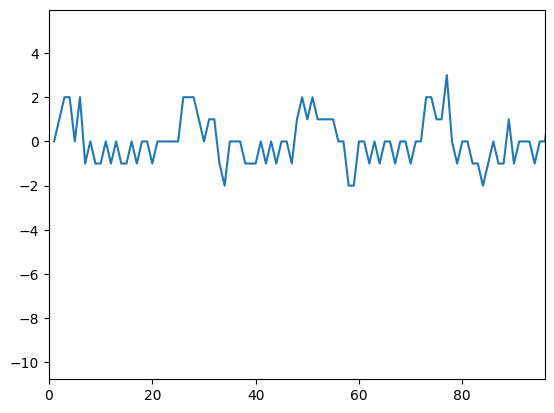

In [173]:
# Take the first differnce
first_diff = data[dimension].diff()[1:]

print("First diff overview")
print(first_diff)

result_adf = adfuller(first_diff)
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])
print('Critical Values:')
for key, value in result_adf[4].items():
    print(f'   {key}: {value}')

# Plotting first difference
plt.plot(first_diff.index, first_diff)
plt.xlim(0, count)
plt.show()

## c. Deciding SARIMA orders using ACF/PACF

### ACF (MA)

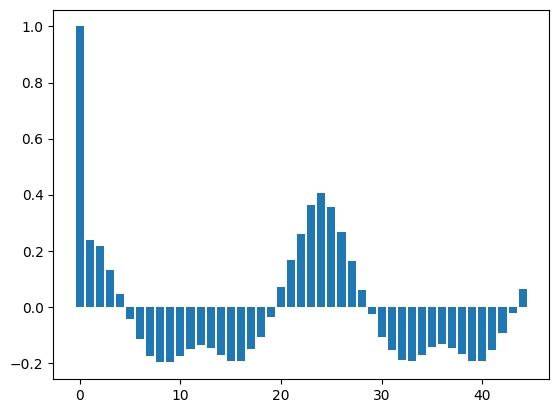

ACF Largest significance:  [0.26042872 0.26776746 0.3576765  0.36405652 0.40729358 1.        ]  from hours  [22 26 25 23 24  0]


In [174]:
acf_result = sm.tsa.acf(first_diff)
num_lags = len(acf_result)
plt.bar(range(num_lags), acf_result[:num_lags])
plt.show()

# Get the indices of the five largest values
largest_indices = np.argsort(np.abs(acf_result))[-6:]
largest_values = acf_result[largest_indices]

print("ACF Largest significance: ", str(largest_values), " from hours ", str(largest_indices))

### PACF (AR)

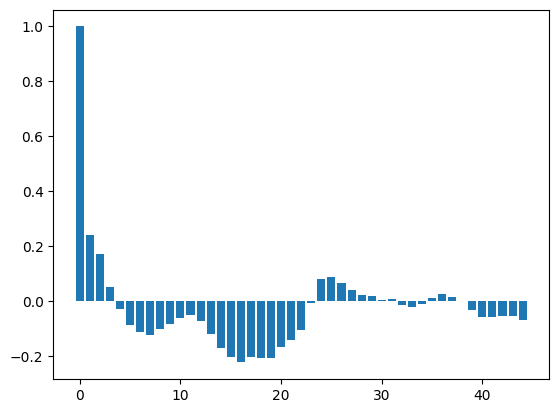

PACF Largest significance:  [-0.20514905 -0.20536022 -0.20542665 -0.22342691  0.23905265  1.        ]  from hours  [15 19 18 16  1  0]


In [175]:
pacf_result = sm.tsa.pacf(first_diff)
num_lags = len(pacf_result)
plt.bar(range(num_lags), pacf_result[:num_lags])
plt.show()

# Get the indices of the five largest values
largest_indices = np.argsort(np.abs(pacf_result))[-6:]
largest_values = pacf_result[largest_indices]

print("PACF Largest significance: ", str(largest_values), " from hours ", str(largest_indices))

# 3. Implementing SARIMA

## a. Normal SARIMA

### Splitting train/test sets

In [176]:
# Set how far into the future will the model forecast
forecast_limit = entry_cycle # 24 hours default

#data = (read_frame(Entry.objects.all())[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)

# Chooose a start date
start_date = dt.datetime(2017, 1, 1).replace(tzinfo=pytz.UTC)
data = (read_frame(Entry.objects.filter(Q(time__gte=start_date)))[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)
data = data[dimensions].astype(np.float64)

# Splitting train and test set
train_set = data.iloc[:math.floor(len(data) * 0.8)].copy(deep=True)
test_set = data.iloc[math.floor(len(data) * 0.8):].copy(deep=True)
test_set.reset_index(drop=True, inplace=True)

# Preparing predictions set
predictions = test_set.iloc[:forecast_limit].copy(deep=True)
predictions.reset_index(drop=True, inplace=True)

### Preview train/test set

In [177]:
train_set

,temp,dwpt,rhum,wdir,wspd,pres
0,23.0,23.0,100.0,350.0,7.6,1012.0
1,25.0,23.1,89.0,20.0,11.2,1012.0
2,28.0,21.1,66.0,40.0,11.2,1012.0
3,30.0,21.1,59.0,30.0,14.8,1011.0
4,31.0,20.0,52.0,20.0,13.0,1011.0
...,...,...,...,...,...,...
51191,25.0,24.0,94.0,225.0,1.8,1013.0
51192,25.0,24.0,94.0,30.0,5.4,1013.0
51193,25.0,24.0,94.0,212.0,3.6,1013.0
51194,25.0,24.0,94.0,187.0,1.8,1014.0


In [178]:
test_set

,temp,dwpt,rhum,wdir,wspd,pres
0,29.0,25.0,79.0,34.0,3.6,1014.0
1,30.0,23.9,70.0,340.0,9.4,1013.0
2,31.0,25.1,71.0,30.0,7.6,1013.0
3,32.0,24.1,63.0,320.0,5.4,1011.0
4,33.0,23.1,56.0,55.0,3.6,1010.0
...,...,...,...,...,...,...
12794,35.0,23.0,50.0,190.0,11.0,1010.0
12795,35.0,23.0,50.0,130.0,17.0,1008.0
12796,36.3,21.0,41.0,71.0,9.3,1007.6
12797,35.9,21.0,42.0,59.0,11.1,1006.7


### SARIMA implementation

In [179]:
# Setting SARIMA order
non_seasonal_component = (2,1,2)
seasonal_component = (2, 0, 3, 8)

# Conducting SARIMA    
for dimension in tqdm(dimensions, desc="Processing dimensions..."):
    # Init SARIMAX model
    model = SARIMAX(np.asarray(train_set[dimension]), order=non_seasonal_component, seasonal_order=seasonal_component)
    model_fit = model.fit()

    # Making predictions
    prediction = model_fit.forecast(forecast_limit)
    predictions.loc[:,dimension] = prediction
print("Done!")

Processing dimensions...: 100%|███████████████████████████████████████████████| 6/6 [12:11<00:00, 121.83s/it]

Done!


### Prediction

In [180]:
predictions

,temp,dwpt,rhum,wdir,wspd,pres
0,28.055356,24.804062,84.399296,105.638620,4.875032,1012.804549
1,28.980850,24.550243,78.186666,116.190502,6.477006,1012.721619
2,29.746530,24.531342,75.000682,122.523429,6.825821,1012.570109
3,30.317935,24.379217,71.907243,128.604142,7.929578,1012.237077
4,30.457358,24.281656,70.410669,134.622294,7.910035,1011.918125
5,30.301050,24.239502,71.889774,127.245888,7.960012,1011.639812
6,29.680923,24.072153,73.279856,131.900580,8.002946,1011.524285
7,29.109266,24.026735,75.841829,137.971572,8.051428,1011.538568
8,28.211251,24.034103,79.497713,135.675796,8.202550,1011.702312
9,27.524264,24.214576,83.288543,136.132112,7.045888,1011.971262


In [181]:
test_set[:len(predictions)]

,temp,dwpt,rhum,wdir,wspd,pres
0,29.0,25.0,79.0,34.0,3.6,1014.0
1,30.0,23.9,70.0,340.0,9.4,1013.0
2,31.0,25.1,71.0,30.0,7.6,1013.0
3,32.0,24.1,63.0,320.0,5.4,1011.0
4,33.0,23.1,56.0,55.0,3.6,1010.0
5,32.0,23.0,59.0,58.0,5.4,1009.0
6,32.0,23.0,59.0,160.0,7.6,1009.0
7,31.0,26.0,75.0,120.0,14.8,1010.0
8,28.0,25.0,84.0,190.0,9.4,1011.0
9,26.0,25.0,94.0,260.0,3.6,1012.0


### Calculating residuals and error

In [182]:
residuals = test_set[:len(predictions)] - predictions
residuals = residuals
residuals

,temp,dwpt,rhum,wdir,wspd,pres
0,0.944644,0.195938,-5.399296,-71.638620,-1.275032,1.195451
1,1.019150,-0.650243,-8.186666,223.809498,2.922994,0.278381
2,1.253470,0.568658,-4.000682,-92.523429,0.774179,0.429891
3,1.682065,-0.279217,-8.907243,191.395858,-2.529578,-1.237077
4,2.542642,-1.181656,-14.410669,-79.622294,-4.310035,-1.918125
5,1.698950,-1.239502,-12.889774,-69.245888,-2.560012,-2.639812
6,2.319077,-1.072153,-14.279856,28.099420,-0.402946,-2.524285
7,1.890734,1.973265,-0.841829,-17.971572,6.748572,-1.538568
8,-0.211251,0.965897,4.502287,54.324204,1.197450,-0.702312
9,-1.524264,0.785424,10.711457,123.867888,-3.445888,0.028738


In [183]:
entry_error = abs(residuals/ test_set[:len(predictions)])
error = entry_error.mean()
error = error*100
error

temp    3.264093
dwpt    3.232623
rhum    7.236742
wdir         inf
wspd         inf
pres    0.098085
dtype: float64

### Visualization

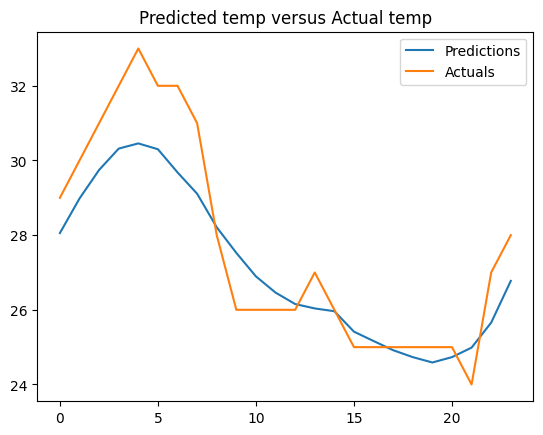

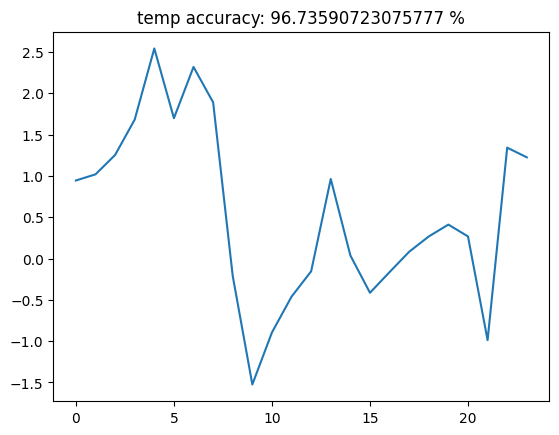

In [184]:
# Choose feature to visualize
d = 'temp'
limit = len(predictions)

# Predicted vs Actual
plt.plot(predictions[d].iloc[:limit], label='Predictions')
plt.plot(test_set[d].iloc[:limit], label='Actuals')
plt.legend()
plt.title('Predicted ' + d + ' versus Actual ' + d)
plt.show()

# Residuals
plt.plot(residuals[d])
plt.title(d + " accuracy: " + str(100 - abs(error[d])) + " %")
plt.show()

## b. Rolling SARIMA (Using actual values)

In [185]:
# Set how far into the future will the model forecast
forecast_limit = entry_cycle # 24 hours default

#data = (read_frame(Entry.objects.all())[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)

# Chooose a start date
start_date = dt.datetime(2020, 1, 1).replace(tzinfo=pytz.UTC)
data = (read_frame(Entry.objects.filter(Q(time__gte=start_date)))[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)
data = data[dimensions].astype(np.float64)

# Splitting train and test set
train_set = data.iloc[:math.floor(len(data) * 0.8)].copy(deep=True)
test_set = data.iloc[math.floor(len(data) * 0.8):].copy(deep=True)
test_set.reset_index(drop=True, inplace=True)

# Preparing predictions set
predictions = test_set.iloc[:forecast_limit].copy(deep=True)
predictions.reset_index(drop=True, inplace=True)

### Rolling SARIMA implementation

In [186]:
# Setting SARIMA order
non_seasonal_component = (2,1,2)
seasonal_component = (2, 0, 3, 8)

for increment in tqdm(range(0,forecast_limit), desc="Predicting future entries..."):
    # Increment train_set
    train_set = data.iloc[:math.floor(len(data) * 0.8)+increment]
    
    # Conducting rolling SARIMA    
    for dimension in dimensions:
        # Init SARIMAX model
        model = SARIMAX(np.asarray(train_set[dimension]), order=non_seasonal_component, seasonal_order=seasonal_component)
        model_fit = model.fit()

        # Making predictions
        prediction = model_fit.forecast()
        predictions.loc[increment,dimension] = prediction
print("Done!")

Predicting future entries...:  50%|██████████████████▌                  | 12/24 [1:20:18<1:17:57, 389.81s/it]ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Predicting future entries...: 100%|███████████████████████████████████████| 24/24 [2:37:08<00:00, 392.87s/it]

Done!


### Prediction's error

In [187]:
predictions

,temp,dwpt,rhum,wdir,wspd,pres
0,26.144532,25.152330,94.456476,245.792911,10.788400,1008.968433
1,26.765865,25.912300,95.108916,228.792187,11.848710,1009.094509
2,26.071175,26.003150,99.730584,230.079886,11.510502,1009.042404
3,26.173545,25.271382,95.145763,228.976165,8.381236,1008.706164
4,26.095598,25.235436,94.403577,224.325358,8.638554,1007.919373
5,25.935944,25.964652,100.447394,252.336427,8.672404,1008.168504
6,26.169358,25.979913,99.262411,241.107341,13.468408,1008.246911
7,25.507997,25.233834,98.867633,248.037568,15.478914,1008.688187
8,26.167777,24.767902,92.861205,259.906865,10.514926,1008.680902
9,27.428419,25.297199,89.241290,255.166120,9.533875,1008.551684


In [188]:
residuals = test_set[:len(predictions)] - predictions
residuals = residuals
entry_error = abs(residuals/ test_set[:len(predictions)])
error = entry_error.mean()
error = error*100
error

temp     2.367590
dwpt     1.831340
rhum     4.346230
wdir     8.542997
wspd    40.660902
pres     0.044664
dtype: float64

### Visualization

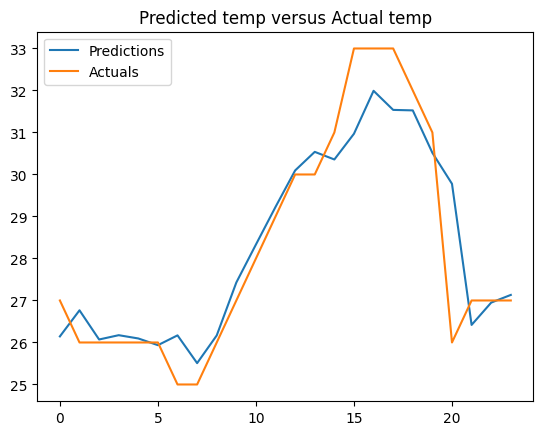

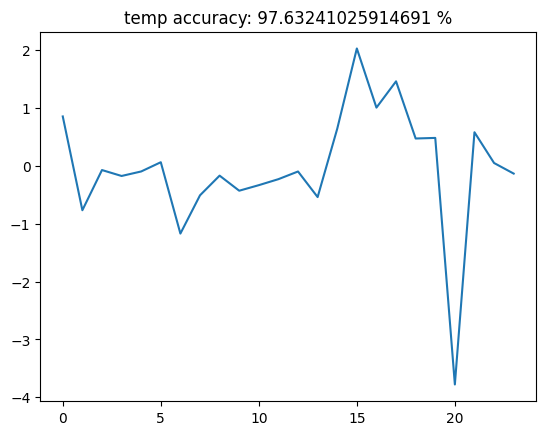

In [189]:
# Choose feature to visualize
d = 'temp'
limit = len(predictions)

# Predicted vs Actual
plt.plot(predictions[d].iloc[:limit], label='Predictions')
plt.plot(test_set[d].iloc[:limit], label='Actuals')
plt.legend()
plt.title('Predicted ' + d + ' versus Actual ' + d)
plt.show()

# Residuals
plt.plot(residuals[d])
plt.title(d + " accuracy: " + str(100 - abs(error[d])) + " %")
plt.show()

## c. Rolling SARIMA (Using predicted values)

### Prep

In [190]:
#data = (read_frame(Entry.objects.all())[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)

# Chooose a start date
start_date = dt.datetime(2021, 1, 1).replace(tzinfo=pytz.UTC)
data = (read_frame(Entry.objects.filter(Q(time__gte=start_date)))[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)
data = data[dimensions].astype(np.float64)

# Splitting train and test set
train_set = data.iloc[:math.floor(len(data) * 0.8)].copy(deep=True)
test_set = data.iloc[math.floor(len(data) * 0.8):].copy(deep=True)
test_set.reset_index(drop=True, inplace=True)

# Preparing predictions set
predictions = test_set.iloc[:forecast_limit].copy(deep=True)
predictions.reset_index(drop=True, inplace=True)

### Rolling SARIMA implementation

In [191]:
# Implement rolling SARIMAX

# Setting SARIMA order
non_seasonal_component = (2,1,2)
seasonal_component = (2, 0, 3, 8)

# Conducting rolling SARIMA    
for index in tqdm(range(0,forecast_limit)):
    # Append newly predicted entries (Rolling)
    if index != 0:
        row_to_append = predictions.iloc[[index-1]]
        train_set = pd.concat([train_set, row_to_append], ignore_index=True)
    
    for dimension in dimensions:
        # Init SARIMAX model
        model = SARIMAX(np.asarray(train_set[dimension]), order=non_seasonal_component, seasonal_order=seasonal_component)
        model_fit = model.fit()

        # Making predictions
        prediction = model_fit.forecast()
        predictions.loc[index, dimension] = prediction

 50%|███████████████████████████████████▌                                   | 12/24 [59:16<59:12, 296.03s/it]ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


100%|█████████████████████████████████████████████████████████████████████| 24/24 [1:58:39<00:00, 296.66s/it]


### Prediction's error

In [192]:
predictions

,temp,dwpt,rhum,wdir,wspd,pres
0,27.033356,26.862481,100.091269,252.651484,13.874705,1008.038304
1,26.968738,26.691112,99.436602,251.564210,13.004364,1008.184316
2,27.292832,26.684074,97.814741,250.606319,12.240294,1008.479521
3,28.033220,26.799646,95.610199,249.555190,13.379968,1009.224222
4,29.095464,26.975841,91.483901,252.136108,14.994729,1009.485604
5,30.177934,26.847308,84.626730,249.839264,16.005263,1009.577555
6,31.142723,26.730637,79.335654,249.161073,16.490621,1009.217832
7,31.847112,26.428408,74.017807,250.188905,17.593823,1008.810265
8,32.294380,26.387662,71.729036,249.568006,18.089180,1007.983001
9,32.584208,26.238473,69.591464,250.635080,18.984903,1007.040138


In [193]:
residuals = test_set[:len(predictions)] - predictions
residuals = residuals
entry_error = abs(residuals/ test_set[:len(predictions)])
error = entry_error.mean()
error = error*100
error

temp     3.978436
dwpt     2.646088
rhum     9.505037
wdir     6.012110
wspd    34.631455
pres     0.037178
dtype: float64

### Visualization

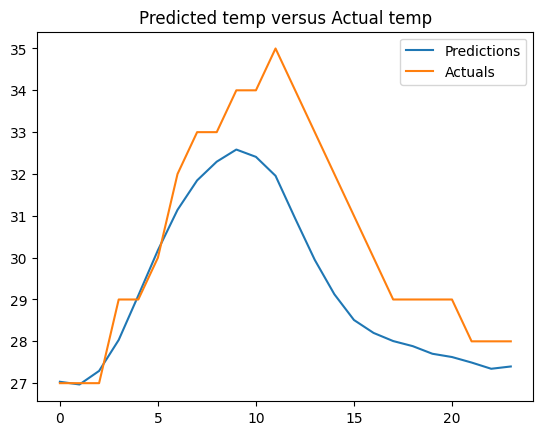

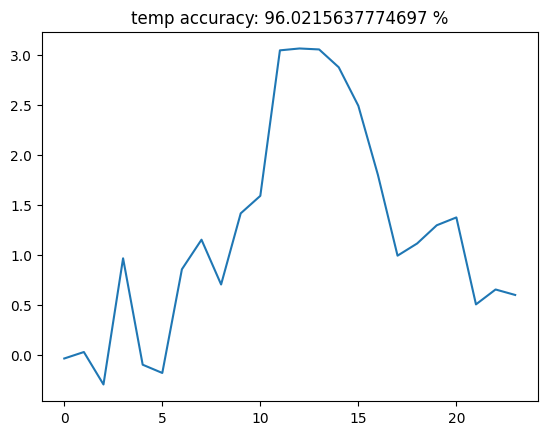

In [194]:
# Choose feature to visualize
d = 'temp'
limit = len(predictions)

# Predicted vs Actual
plt.plot(predictions[d].iloc[:limit], label='Predictions')
plt.plot(test_set[d].iloc[:limit], label='Actuals')
plt.legend()
plt.title('Predicted ' + d + ' versus Actual ' + d)
plt.show()

# Residuals
plt.plot(residuals[d])
plt.title(d + " accuracy: " + str(100 - abs(error[d])) + " %")
plt.show()

# 4. Predicting features separately

## a. Stationary check (Adfuller)

In [319]:
start_date = dt.datetime(2017, 1, 1).replace(tzinfo=pytz.UTC)
data = (read_frame(Entry.objects.filter(Q(time__gte=start_date)))[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)

data['pres'] = data['pres'] - 1000

In [320]:
dimension = "pres"
count = 24*3

### No difference

In [321]:
result_adf = adfuller(data[dimension])

# Print the results
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])
print('Critical Values:')
for key, value in result_adf[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -15.640969208572468
p-value: 1.6404780969825264e-28
Critical Values:
   1%: -3.4304522861477684
   5%: -2.861585208593774
   10%: -2.566794063001469


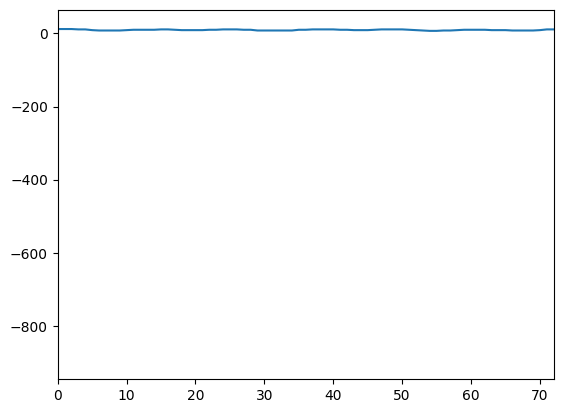

In [322]:
# Plotting temperature
plt.plot(data.index, data[dimension])
plt.xlim(data.iloc[0].name, data.iloc[count].name)
plt.show()

### First difference

First diff overview
1         0.0
2         0.0
3        -1.0
4         0.0
5        -2.0
         ... 
63990     0.0
63991    -2.0
63992    -0.4
63993    -0.9
63994    -0.9
Name: pres, Length: 63994, dtype: object
ADF Statistic: -50.42962315448116
p-value: 0.0
Critical Values:
   1%: -3.4304522877477286
   5%: -2.8615852093009146
   10%: -2.5667940633778583


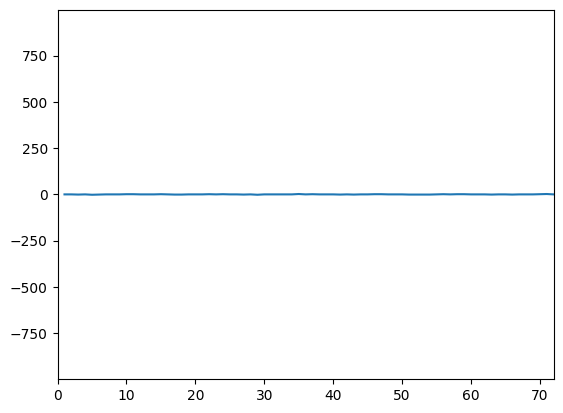

In [323]:
# Take the first differnce
first_diff = data[dimension].diff()[1:]
# first_diff = data[dimension]


print("First diff overview")
print(first_diff)

result_adf = adfuller(first_diff)
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])
print('Critical Values:')
for key, value in result_adf[4].items():
    print(f'   {key}: {value}')

# Plotting first difference
plt.plot(first_diff.index, first_diff)
plt.xlim(0, count)
plt.show()

## b. Deciding SARIMA orders using ACF/PACF

### ACF (MA)

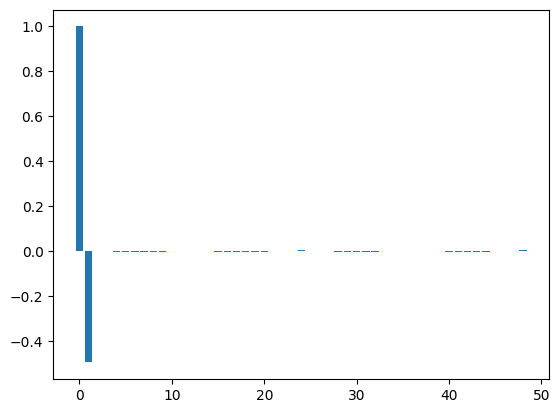

ACF Largest significance:  [-0.00377032 -0.00382898 -0.00399276  0.00445078  0.0046633  -0.49387618]  from hours  [18  6 30 24 48  1]
[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


In [324]:
acf_result = sm.tsa.acf(first_diff)
num_lags = len(acf_result)
plt.bar(range(num_lags), acf_result[:num_lags])
plt.show()

# Get the indices of the five largest values
largest_indices = np.argsort(np.abs(acf_result))[-7:]
largest_values = acf_result[largest_indices]

# Remove the first lag
largest_indices = largest_indices[:-1]
largest_values = largest_values[:-1]

print("ACF Largest significance: ", str(largest_values), " from hours ", str(largest_indices))

# Deciding seasonal order
orderMA = [0] * len(acf_result)

for index in (largest_indices-1):
    if 0 <= index < len(orderMA):
        orderMA[index] = 1
    
print(orderMA)

### PACF (AR)

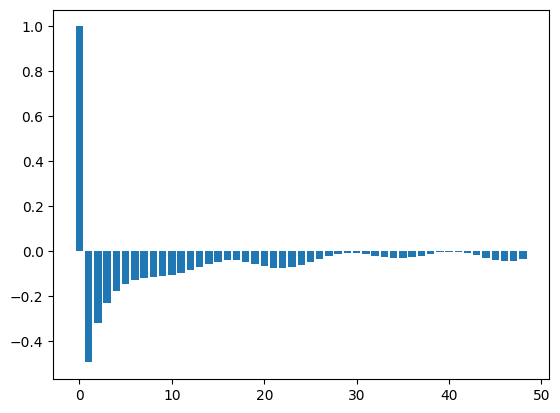

PACF Largest significance:  [-0.12895114 -0.14575729 -0.17662315 -0.22969602 -0.31938963 -0.49388389]  from hours  [6 5 4 3 2 1]
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [325]:
pacf_result = sm.tsa.pacf(first_diff)
num_lags = len(pacf_result)
plt.bar(range(num_lags), pacf_result[:num_lags])
plt.show()

# Get the indices of the five largest values
largest_indices = np.argsort(np.abs(pacf_result))[-7:]
largest_values = pacf_result[largest_indices]

# Remove the first lag
largest_indices = largest_indices[:-1]
largest_values = largest_values[:-1]

print("PACF Largest significance: ", str(largest_values), " from hours ", str(largest_indices))

# Deciding seasonal order
orderAR = [0] * len(pacf_result)

for index in (largest_indices-1):
    if 0 <= index < len(orderAR):
        orderAR[index] = 1
    
print(orderAR)

In [326]:
def remove_trailing_zeros(array):
    try:
        last_one_index = len(array) - array[::-1].index(1)
        return array[:last_one_index]
    except ValueError:
        return []

# Example usage:
orderMA = remove_trailing_zeros(orderMA)
orderAR = remove_trailing_zeros(orderAR)

In [314]:
order = (orderAR, 1, orderMA)
print(order)

([1, 1, 1, 1, 1, 1], 1, [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])


## c. SARIMA

In [327]:
# Set how far into the future will the model forecast
forecast_limit = entry_cycle # 24 hours default

#data = (read_frame(Entry.objects.all())[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)

# Chooose a start date
start_date = dt.datetime(2017, 1, 1).replace(tzinfo=pytz.UTC)
data = (read_frame(Entry.objects.filter(Q(time__gte=start_date)))[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)
data = data[dimensions].astype(np.float64)

data['pres'] = data['pres'] - 1000

# Splitting train and test set
train_set = data.iloc[:math.floor(len(data) * 0.8)].copy(deep=True)
test_set = data.iloc[math.floor(len(data) * 0.8):].copy(deep=True)
test_set.reset_index(drop=True, inplace=True)

# Preparing predictions set
predictions = test_set.iloc[:forecast_limit].copy(deep=True)
predictions.reset_index(drop=True, inplace=True)

# SARIMA WAY

In [331]:
non_seasonal_component =(2,0,2)
seasonal_component = (4,0,4,12)

# Init SARIMAX model
model = SARIMAX(np.asarray(train_set[dimension]), order=non_seasonal_component, seasonal_order=seasonal_component)
model_fit = model.fit(method='lbfgs')

# Making predictions
prediction = model_fit.forecast(forecast_limit)
predictions.loc[:,dimension] = prediction
print("Done!")

Done!


In [332]:
# Deallocate memory
del model
del model_fit
gc.collect()

2872

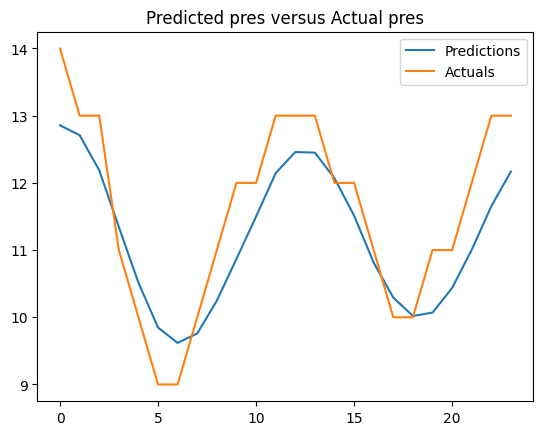

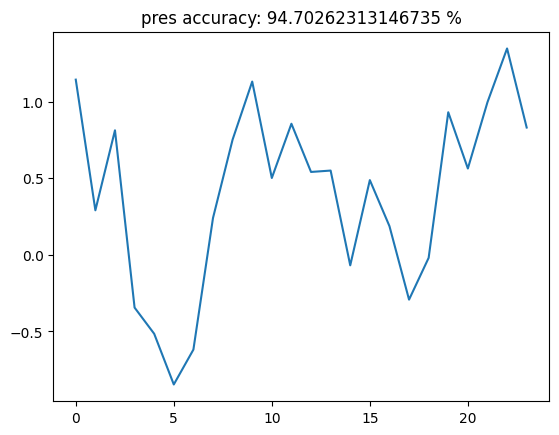

In [333]:
residuals = test_set[:len(predictions)] - predictions

entry_error = abs(residuals/ test_set[:len(predictions)])
error = entry_error.mean()
error = error*100

# Choose feature to visualize
d = dimension
limit = len(predictions)

# Predicted vs Actual
plt.plot(predictions[d].iloc[:limit], label='Predictions')
plt.plot(test_set[d].iloc[:limit], label='Actuals')
plt.legend()
plt.title('Predicted ' + d + ' versus Actual ' + d)
plt.show()

# Residuals
plt.plot(residuals[d])
plt.title(d + " accuracy: " + str(100 - abs(error[d])) + " %")
plt.show()

# 5. Polinomial regression to classify/foreacst/predict weather conditions

## a. Polinomial regression to predict risk of rain

### Preparing dataset for fitting

In [111]:
#data = (read_frame(Entry.objects.all())[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)

# Chooose a start date
start_date = dt.datetime(2020, 1, 1).replace(tzinfo=pytz.UTC)
data = (read_frame(Entry.objects.filter(Q(time__gte=start_date)))).copy(deep=True)
data[dimensions] = data[dimensions].astype(np.float64)

# Filter nan (0) values
data = data[data['coco'] != 0]

# Dictionary reduced to a few categories
rain_or_not = {1: 0, 
                2: 0, 
                3: 0, 
                4: 0, 
                5: 0,
                7: 1,
                8: 1,
                9: 1,
                17: 1,
                18: 1,
                25: 1,
                26: 1,
                27: 1,}

# Map available conditions
data['coco'] = data['coco'].map(rain_or_not)

# Convert to int and -1 
data['coco'] = data['coco'].astype(int)

# Dropping unecessary columns
data = data.drop(columns=['id', 'time'])

In [112]:
data['coco'].value_counts()

coco
0    24252
1     6411
Name: count, dtype: int64

### Performing polinomal regression

In [113]:
# Random seed
np.random.seed(69)

# Splitting train/test sets
train_set = data.sample(frac=0.8)
test_set = data.drop(train_set.index)

# Preparing point/label training sets
train_point_set = train_set.drop(columns=['coco'])
# Encode train label into binary
train_label_set = train_set['coco']

# Create polynomial features of degree 6
poly_features = PolynomialFeatures(degree=4)
poly = poly_features.fit_transform(train_point_set)

# Fit linear regression model on le polynomial features
model = LinearRegression()
model.fit(poly, train_label_set)

# Preparing point/label testing sets
test_point_set = test_set.drop(columns=['coco'])
test_label_set = test_set['coco']

# Prediction
X_plot_poly = poly_features.transform(test_point_set)
y_pred = model.predict(X_plot_poly)

# Convert to dataframe
y_pred = pd.DataFrame(y_pred.round())
y_pred = y_pred.astype(int)

acc = 100*accuracy_score(test_label_set.values.ravel(), y_pred.values.ravel())
print(acc)

y_pred = pd.DataFrame(y_pred.round())
y_pred

82.21098972770258


,0
0,0
1,0
2,0
3,0
4,0
...,...
6128,0
6129,0
6130,0
6131,0


In [118]:
print(y_pred.value_counts())

test_label_set.value_counts()

0
0    5511
1     622
Name: count, dtype: int64


coco
0    4840
1    1293
Name: count, dtype: int64

 ## b. Polinomial regression to predict condition code (volatile)

### Preparing dataset for fitting

In [56]:
#data = (read_frame(Entry.objects.all())[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)

# Chooose a start date
start_date = dt.datetime(2020, 1, 1).replace(tzinfo=pytz.UTC)
data = (read_frame(Entry.objects.filter(Q(time__gte=start_date)))).copy(deep=True)
data[dimensions] = data[dimensions].astype(np.float64)

# Filter nan (0) values
data = data[data['coco'] != 0]

# Dictionary reduced to a few categories
mapping_dict = {1: 0, 
                2: 0, 
                3: 1, 
                4: 1, 
                5: 1,
                7: 2,
                8: 2,
                9: 2,
                17: 3,
                18: 3,
                25: 4,
                26: 4,
                27: 4,}

# Map available conditions
data['coco'] = data['coco'].map(mapping_dict)

# Convert to int and -1 
data['coco'] = data['coco'].astype(int)

# Dropping unecessary columns
data = data.drop(columns=['id', 'time'])

### Performing polinomal regression

In [57]:
data['coco'].value_counts()

coco
0    16718
1     7529
2     4498
4     1093
3      820
Name: count, dtype: int64

In [59]:
# Random seed
np.random.seed(42)

# Splitting train/test sets
train_set = data.sample(frac=0.8)
test_set = data.drop(train_set.index)

# Preparing point/label training sets
train_point_set = train_set.drop(columns=['coco'])
# Encode train label into binary
binary_encoder = ce.BinaryEncoder(cols=['coco'])
train_label_set = binary_encoder.fit_transform(train_set[['coco']])

# Create polynomial features of degree 6
poly_features = PolynomialFeatures(degree=6)
poly = poly_features.fit_transform(train_point_set)

# Fit linear regression model on le polynomial features
model = LinearRegression()
model.fit(poly, train_label_set)

# Preparing point/label testing sets
test_point_set = test_set.drop(columns=['coco'])
test_label_set = binary_encoder.fit_transform(test_set[['coco']])

# Prediction
X_plot_poly = poly_features.transform(test_point_set)
y_pred = model.predict(X_plot_poly)

# Convert to dataframe
y_pred = pd.DataFrame(y_pred.round())
y_pred = y_pred.astype(int)

acc = 100*accuracy_score(test_label_set.values.ravel(), y_pred.values.ravel())
print(acc)

y_pred = pd.DataFrame(y_pred.round())
y_pred

73.40182648401826


,0,1,2
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
6127,0,1,1
6128,0,0,1
6129,0,0,1
6130,0,0,1


In [78]:
train_set = (read_frame(Entry.objects.all())[['time','temp','dwpt','rhum','wdir','wspd','pres','coco']]).copy(deep=True)

# Preparing predictions set
predictions = (read_frame(Entry.objects.all().order_by('-id')[:entry_cycle])[['time','temp','dwpt','rhum','wdir','wspd','pres','coco']]).copy(deep=True)
predictions = predictions.sort_values(by='time')
predictions.reset_index(drop=True, inplace=True)

# Converting from decimal to numpy float64
train_set[dimensions] = train_set[dimensions].astype(np.float64)
predictions[dimensions] = predictions[dimensions].astype(np.float64)

for index in range(0,len(predictions)):
    predictions.loc[index, 'time'] += dt.timedelta(hours=entry_cycle)
        
    # Conduct SARIMA on every dimension/feature
#     for dimension in tqdm(dimensions, desc="Predicting the next day's features..."):
#         # Init SARIMAX model
#         model = SARIMAX(np.asarray(train_set[dimension]), order=non_seasonal_component, seasonal_order=seasonal_component)
#         model_fit = model.fit()

#         # Making predictions
#         prediction = model_fit.forecast(entry_cycle)
#         predictions[dimension] = prediction
        
    # Create + save prediction instance
#     current_time = train_set.iloc[-1].time
#     new_prediction_ins = Prediction(prediction_time=current_time, predicted_entry_count=entry_cycle)
#     new_prediction_ins.save()
    
    # Predict weather condition
#     predictions = coco(predictions)
    
    # Create + save predicted entries
#     for i in tqdm(range(len(predictions)), desc="Saving predicted values..."):
#             Predicted_Entry.add_entry(predictions.iloc[i], new_prediction_ins)

In [79]:
predictions

,time,temp,dwpt,rhum,wdir,wspd,pres,coco
0,2024-04-11 12:00:00+00:00,30.4,22.0,61.0,68.0,14.8,1009.1,2
1,2024-04-11 13:00:00+00:00,29.5,22.5,66.0,69.0,11.1,1009.9,2
2,2024-04-11 14:00:00+00:00,28.7,22.9,71.0,70.0,9.3,1010.6,2
3,2024-04-11 15:00:00+00:00,27.9,23.3,76.0,76.0,5.5,1011.3,1
4,2024-04-11 16:00:00+00:00,27.3,23.3,79.0,86.0,5.5,1011.1,1
5,2024-04-11 17:00:00+00:00,26.7,23.8,84.0,110.0,3.7,1011.0,1
6,2024-04-11 18:00:00+00:00,26.1,24.0,88.0,161.0,3.7,1010.8,1
7,2024-04-11 19:00:00+00:00,25.6,23.7,89.0,151.0,3.7,1010.5,1
8,2024-04-11 20:00:00+00:00,25.2,23.6,91.0,139.0,3.7,1010.1,1
9,2024-04-11 21:00:00+00:00,24.8,23.6,93.0,126.0,3.7,1009.8,1


In [80]:
    # Preparing trainin set
    # Chooose a start date
    start_date = dt.datetime(2020, 1, 1).replace(tzinfo=pytz.UTC)

    # Getting data from database
    data = (read_frame(Entry.objects.filter(Q(time__gte=start_date)))).copy(deep=True)
    data[dimensions] = data[dimensions].astype(np.float64)

    # Filter nan (0) values
    data = data[data['coco'] != 0]

    # Map available conditions
    data['coco'] = data['coco'].map(rain_or_not)

    # Convert to int and -1 
    data['coco'] = data['coco'].astype(int)    

    # Splitting point/label set
    data_point_set = data.drop(columns=['coco', 'time', 'id'])
    # Encode train label into binary
    data_label_set = data['coco']

    # Create polynomial features of degree 6
    poly_features = PolynomialFeatures(degree=4)
    poly = poly_features.fit_transform(data_point_set)

    # Fit linear regression model on le polynomial features
    model = LinearRegression()
    model.fit(poly, data_label_set)

    # Making predictions
    X_plot_poly = poly_features.transform(predictions[dimensions])
    y_pred = model.predict(X_plot_poly)

    # Convert to dataframe
    y_pred = np.clip(y_pred, 0, 1)
    
    # Change prediction's column
    predictions['risk'] = y_pred

In [85]:
predictions.iloc[23].risk

0.28314542790758424

# PRedicting coco

In [77]:
# Preparing trainin set
# Chooose a start date
start_date = dt.datetime(2020, 1, 1).replace(tzinfo=pytz.UTC)

# Getting data from database
data = (read_frame(Entry.objects.filter(Q(time__gte=start_date)))).copy(deep=True)
data[dimensions] = data[dimensions].astype(np.float64)

# Filter nan (0) values
data = data[data['coco'] != 0]

mapping_dict = {1: 0, 
            2: 0, 
            3: 1, 
            4: 1, 
            5: 1,
            7: 2,
            8: 2,
            9: 2,
            17: 3,
            18: 3,
            25: 4,
            26: 4,
            27: 4,}

# Map available conditions
data['coco'] = data['coco'].map(mapping_dict)

# Convert to int and -1 
data['coco'] = data['coco'].astype(int)    

# Splitting point/label set
data_point_set = data.drop(columns=['coco', 'time', 'id'])
# Encode train label into binary
binary_encoder = ce.BinaryEncoder(cols=['coco'])
data_label_set = binary_encoder.fit_transform(data[['coco']])

# Create polynomial features of degree 6
poly_features = PolynomialFeatures(degree=6)
poly = poly_features.fit_transform(data_point_set)

# Fit linear regression model on le polynomial features
model = LinearRegression()
model.fit(poly, data_label_set)

# Making predictions
X_plot_poly = poly_features.transform(predictions[dimensions])
y_pred = model.predict(X_plot_poly)

# Convert to dataframe
y_pred = np.clip(y_pred, 0, 1)
y_pred = y_pred.round()
y_pred = y_pred.astype(int)

# Inverse transform
column_names = ['coco_0', 'coco_1', 'coco_2']
y_pred = pd.DataFrame(y_pred, columns=column_names)
y_pred_trans = pd.DataFrame(columns=['coco'])
for i in range(0,len(y_pred)):
    try:
        y_pred_trans.loc[i] = [binary_encoder.inverse_transform(pd.DataFrame(y_pred.iloc[i]).T).iloc[0].coco]
    except Exception as e:
        y_pred_trans.loc[i] = [-1]

# Align with the db norm
y_pred_trans += 1

# Change prediction's column
predictions['coco'] = y_pred_trans['coco']

In [76]:
predictions.iloc[1].risk

0.1558749238756718

# ?. Function to calculate accuracy

In [30]:
# Getting predictions that have been predicted over 24 hours ago
est_elapsed = (dt.datetime.utcnow() - dt.timedelta(hours=entry_cycle)).replace(tzinfo=pytz.utc)
predictions = Prediction.objects.filter(Q(prediction_time__lte=est_elapsed))

# Running loop to calculate accuracy of all predictions
for prediction in tqdm(predictions, desc="Calculating accuracy..."):
    if (accuracy!=-1):
        # Getting predicted_entries of a prediction
        prediction_id = prediction.id
        predicted_entries = read_frame(Predicted_Entry.objects.filter(prediction_id=prediction_id)).copy(deep=True)
        
        # Getting start and end time of a prediction
        start_time = predicted_entries.iloc[0]['time']
        end_time = predicted_entries.iloc[-1]['time']
        
        # Dropping unecessary columns
        predicted_entries.drop(columns=['id', 'prediction', 'time', 'coco'], inplace=True)
        
        # Getting actual entries
        actual_entries = read_frame(Entry.objects.filter(time__range=(start_time, end_time))).copy(deep=True)
        actual_entries.drop(columns=['id', 'time', 'coco'], inplace=True)
        
        # Calculating residuals
        error = (actual_entries - predicted_entries).div(actual_entries)
    
        # Calculating error
        error_temp = error['temp'].abs().mean()*100
        error_dwpt = error['dwpt'].abs().mean()*100
        error_rhum = error['rhum'].abs().mean()*100
        error_wdir = error['wdir'].abs().mean()*100
        error_wspd = error['wspd'].abs().mean()*100
        error_pres = error['pres'].abs().mean()*100
        
        # Calculating accuracy
        accuracy_temp = 100 - error_temp
        accuracy_dwpt = 100 - error_dwpt
        accuracy_rhum = 100 - error_rhum
        accuracy_wdir = 100 - error_wdir
        accuracy_wspd = 100 - error_wspd
        accuracy_pres = 100 - error_pres
        
        # Calculating general accuracy and saving
        accuracy = (accuracy_temp + accuracy_dwpt + accuracy_rhum + accuracy_wdir + accuracy_wspd + accuracy_pres)/6
        prediction.accuracy_temp = accuracy_temp
        prediction.accuracy_dwpt = accuracy_dwpt
        prediction.accuracy_rhum = accuracy_rhum
        prediction.accuracy_wdir = accuracy_wdir
        prediction.accuracy_wspd = accuracy_wspd
        prediction.accuracy_pres = accuracy_pres
        prediction.accuracy = accuracy
        prediction.save()

Calculating accuracy...: 100%|████████████████████████| 27/27 [00:00<00:00, 47.07it/s]


# Rolling SARIMA (ineffective)

In [7]:
# train_set = (read_frame(Entry.objects.all())[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)

start_date = datetime(2019, 1, 1)
train_set = (read_frame(Entry.objects.filter(Q(time__gte=start_date)))[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)

# Preparing predictions set
predictions = (read_frame(Entry.objects.all().order_by('-id')[:entry_cycle])[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)
predictions = predictions.sort_values(by='time')
predictions.reset_index(drop=True, inplace=True)

# Converting from decimal to numpy float64
train_set[dimensions] = train_set[dimensions].astype(np.float64)
predictions[dimensions] = predictions[dimensions].astype(np.float64)

for index in range(0,len(predictions)):
    predictions.loc[index, 'time'] += dt.timedelta(hours=entry_cycle)
    
# Implement rolling SARIMAX

# Setting SARIMAX order
non_seasonal_component = (0,1,0)
seasonal_component = (1, 0, 1, 24)

# Conducting rolling SARIMA    
for index in tqdm(range(0,entry_cycle)):
    # Append newly predicted entries (Rolling)
    if index != 0:
        row_to_append = predictions.iloc[[index-1]]
        train_set = pd.concat([train_set, row_to_append], ignore_index=True)
    
    for dimension in dimensions:
        # Init SARIMAX model
        model = SARIMAX(np.asarray(train_set[dimension]), order=non_seasonal_component, seasonal_order=seasonal_component)
        model_fit = model.fit()

        # Making predictions
        prediction = model_fit.forecast()
        predictions.loc[index, dimension] = prediction


100%|████████████████████████████████████████████████| 24/24 [50:02<00:00, 125.11s/it]


In [30]:
predictions

,time,temp,dwpt,rhum,wdir,wspd,pres
0,2024-04-04 10:00:00+00:00,34.674628,21.757842,47.980764,42.039637,14.637410,1006.991213
1,2024-04-04 11:00:00+00:00,33.303306,22.174104,54.106896,40.808411,13.844925,1007.606838
2,2024-04-04 12:00:00+00:00,32.542064,22.385939,57.737553,38.187563,12.622192,1008.212644
3,2024-04-04 13:00:00+00:00,32.004396,22.574329,60.556833,35.461915,12.327889,1008.769428
4,2024-04-04 14:00:00+00:00,31.575220,22.812154,63.128387,33.829363,11.909321,1009.319566
5,2024-04-04 15:00:00+00:00,31.163749,23.044413,65.920817,34.696664,11.577724,1009.783805
6,2024-04-04 16:00:00+00:00,30.837037,23.156653,68.018967,34.475406,11.119053,1009.722441
7,2024-04-04 17:00:00+00:00,30.630219,23.273321,69.525157,38.317964,10.901011,1009.202393
8,2024-04-04 18:00:00+00:00,30.266395,23.383130,71.734188,37.958883,10.106811,1008.777375
9,2024-04-04 19:00:00+00:00,30.036876,23.393718,72.982042,38.862279,10.207509,1008.349168


In [31]:
train_set[len(train_set)-24:]

,time,temp,dwpt,rhum,wdir,wspd,pres
46066,2024-04-03 10:00:00+00:00,33.1,21.3,50.0,67.0,13.0,1006.9
46067,2024-04-03 11:00:00+00:00,31.9,22.3,57.0,72.0,11.1,1007.3
46068,2024-04-03 12:00:00+00:00,30.8,22.9,63.0,78.0,7.4,1007.8
46069,2024-04-03 13:00:00+00:00,29.8,23.3,68.0,81.0,7.4,1008.5
46070,2024-04-03 14:00:00+00:00,28.9,23.6,73.0,92.0,5.5,1009.2
46071,2024-04-03 15:00:00+00:00,27.9,23.9,79.0,187.0,3.7,1009.9
46072,2024-04-03 16:00:00+00:00,27.3,24.0,82.0,197.0,3.7,1009.7
46073,2024-04-03 17:00:00+00:00,26.8,24.1,85.0,203.0,3.7,1009.4
46074,2024-04-03 18:00:00+00:00,26.2,24.1,88.0,206.0,3.7,1009.1
46075,2024-04-03 19:00:00+00:00,25.8,24.0,90.0,208.0,3.7,1008.9


In [22]:
start_date = datetime(2019, 1, 1)
train_set = (read_frame(Entry.objects.filter(Q(time__gte=start_date)))[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)
train_set[dimensions] = train_set[dimensions].astype(np.float64)
train_set

,time,temp,dwpt,rhum,wdir,wspd,pres
0,2019-01-01 00:00:00+00:00,24.0,18.0,69.0,350.0,14.8,1014.0
1,2019-01-01 01:00:00+00:00,24.0,18.0,69.0,350.0,18.4,1014.0
2,2019-01-01 02:00:00+00:00,25.0,18.9,69.0,350.0,18.4,1014.0
3,2019-01-01 03:00:00+00:00,27.0,19.1,62.0,360.0,20.5,1014.0
4,2019-01-01 04:00:00+00:00,27.0,19.1,62.0,360.0,20.5,1013.0
...,...,...,...,...,...,...,...
46085,2024-04-04 05:00:00+00:00,34.8,21.8,47.0,83.0,9.3,1009.5
46086,2024-04-04 06:00:00+00:00,35.9,21.0,42.0,68.0,11.1,1008.7
46087,2024-04-04 07:00:00+00:00,36.0,21.1,42.0,54.0,11.1,1008.0
46088,2024-04-04 08:00:00+00:00,36.0,21.5,43.0,47.0,13.0,1007.2


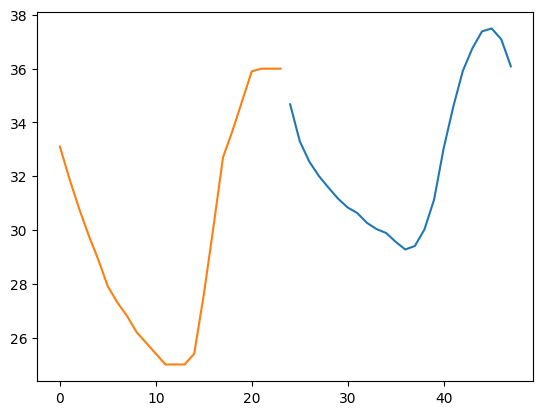

In [32]:
dimension = "temp"

plt.plot(range(24,48),predictions[dimension])
plt.plot(range(0,24),train_set[len(train_set)-24:][dimension])

In [71]:
residuals = 

28544    36.000000
28545    34.960047
28546    33.632776
28547    32.258463
28548    31.496814
28549    30.958965
28550    30.528368
28551    30.115584
28552    29.785685
28553    29.577767
28554    29.211297
28555    28.980574
28556    28.830043
28557    28.500077
28558    28.213512
28559    28.339516
28560    28.957285
28561    30.070677
28562    31.976137
28563    33.526765
28564    34.865752
28565    35.709735
28566    36.340254
28567    36.450807
Name: temp, dtype: float64

In [8]:
Entry.objects.latest()

ValueError: earliest() and latest() require either fields as positional arguments or 'get_latest_by' in the model's Meta.

In [13]:
train_set.iloc[-1].time



Timestamp('2024-04-04 12:00:00+0000', tz='UTC')

In [5]:
start_date = dt.datetime(2022, 1, 1).replace(tzinfo=pytz.UTC)
start_date

datetime.datetime(2022, 1, 1, 0, 0, tzinfo=<UTC>)

In [ ]:
# Random seed
np.random.seed(69)

# Splitting train/test sets
train_set = data.sample(frac=0.8)
test_set = data.drop(train_set.index)

# Preparing point/label training sets
train_point_set = train_set.drop(columns=['coco'])
# Encode train label into binary
binary_encoder = ce.BinaryEncoder(cols=['coco'])
train_label_set = binary_encoder.fit_transform(train_set[['coco']])

# Create polynomial features of degree 6
poly_features = PolynomialFeatures(degree=6)
poly = poly_features.fit_transform(train_point_set)

# Fit linear regression model on le polynomial features
model = LinearRegression()
model.fit(poly, train_label_set)

# Preparing point/label testing sets
test_point_set = test_set.drop(columns=['coco'])
test_label_set = binary_encoder.fit_transform(test_set[['coco']])

# Prediction
X_plot_poly = poly_features.transform(test_point_set)
y_pred = model.predict(X_plot_poly)

# Convert to dataframe
y_pred = pd.DataFrame(y_pred.round())
y_pred = y_pred.astype(int)

acc = 100*accuracy_score(test_label_set.values.ravel(), y_pred.values.ravel())
print(acc)

y_pred = pd.DataFrame(y_pred.round())
y_pred